In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import sys
sys.path.insert(0, "../func_py/")
import infer_gbm as gbm
import data_utils as dtu

import warnings
warnings.filterwarnings("ignore")

In [2]:
metadata = pd.read_csv('metadata/metadata.tsv', sep='\t', index_col=0)

# List containing the 3 inference settings. Each element is composed by:
# - setting label patinet-ntimepoints
# - list of samples used in the inference
# - delta times that separate the samples in years
# - parameters of the gamma import function
pairs_and_dts = [
    ('1', ('pat1_t1_mc', 'pat1_t2_mc'), [10], [4,4]),
    ('2_2', ('pat2_t1_mc', 'pat2_t2_mc'), [6], [4,4]),
    ('2_3', ('pat2_t1_mc', 'pat2_t2_mc', 'pat2_t3_mc'), [6, 1/6], [4,4])
]

### Choosing the sample

In [ ]:
# Inference for sequences
label, samples, dtimes, priors = pairs_and_dts[2]
label += '_seq'
sp_counts = dtu.import_and_build_sparse_counts(samples, fam_label='sequence')

In [3]:
# Inference for clones
label, samples, dtimes, priors = pairs_and_dts[2]
sp_counts = dtu.import_and_build_sparse_counts(samples)

### Scanning the likelihood at fixed M_tot and n0

In [5]:
infer_pars = gbm.gbm_infer_pars(dtimes, 10**7, 20, 1, n_eval=2 * 10**5, prior_pars=[4,4])
max_n1 = max(sp_counts.n1.values)
M1 = np.sum(sp_counts.n1 * sp_counts.occ)
import_f = gbm.get_gamma_prior(max_n1, M1, infer_pars.M_tot, 4, 4)

taus = np.linspace(5, 40, 12)
alphas = np.linspace(0.8, 1.8, 12)
lls = np.zeros((len(taus), len(alphas)))
progress = tqdm(total=len(taus)*len(alphas))
for i, t in enumerate(taus):
    for j, a in enumerate(alphas):
        lls[i,j] = gbm.MC_gbm_full_ll(sp_counts, t, a*t/2.0, infer_pars, import_f)
        progress.update(1)

  0%|          | 0/144 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='alpha', ylabel='tau'>,
 <matplotlib.colorbar.Colorbar at 0x786561004d60>)

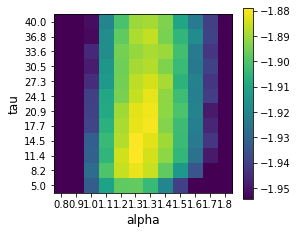

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(4,3.5))

gbm.plot_heatmap(ax1, lls, alphas, taus, np.max(lls) - 0.075, np.max(lls), laby='tau', labx='alpha')
#plt.savefig('plots/gbm/ll_heatmap_pat' + label + '.svg')

### Computing the best likelihood at best tau and theta for different M_tot and n0s

The execturion of the following cells are quite time consuming, of the order of one day or more

In [36]:
# Parameters of the optimization algorithm
pars = {
    'n_eval' : 3 * 10**5,
    'bounds00' : 7.0,
    'bounds01' : 30.0,
    'bounds10' : 1.0,
    'bounds11' : 2.0,
    'gamma_priors0' : priors[0],
    'gamma_priors1' : priors[1],
    'noise' : 1e-2,
    'lenght_scales0' : 50.,
    'lenght_scales1' : 1.,
    'xi' : 2e-4,
    'n_calls' : 50,
    'n_jobs' : 2
}
pd.Series(pars).to_csv('inference/gbm/pars_pat'+label+'_nmin1.tsv', sep='\t')
pref = 'inference/gbm/results_'
post = '_pat'+label+'_nmin1_1.tsv'

# Values of M and n0
n0s = np.logspace(np.log10(2), 3, 12)
M_tots = np.logspace(5.5, 9, 12, dtype=int)
R = 1
lls = np.zeros((len(n0s), len(M_tots), R)) 
taus = np.zeros((len(n0s), len(M_tots), R))
thetas = np.zeros((len(n0s), len(M_tots), R))

In [17]:
progress = tqdm(total=len(n0s)*len(M_tots)*R)
for i, n0 in enumerate(n0s):
    for j, M_tot in enumerate(M_tots):
        for k in range(R):
            prs = [pars['gamma_priors0'], pars['gamma_priors1']]
            infer_pars = gbm.gbm_infer_pars(dtimes, M_tot, n0, 1, pars['n_eval'], prs)
            bounds = [(pars['bounds00'], pars['bounds01']), (pars['bounds10'], pars['bounds11'])]
            ls = [pars['lenght_scales0'], pars['lenght_scales1']]
            res = gbm.learn_gbm_gp(sp_counts, infer_pars, bounds=bounds, n_calls=pars['n_calls'], \
                                   noise=pars['noise'], lenght_scales=ls, xi=pars['xi'], n_jobs=pars['n_jobs'])
            lls[i,j,k] = -res.fun
            taus[i,j,k] = res.x[0]
            thetas[i,j,k] = res.x[1]*res.x[0] / 2.0
            progress.update(1)
            
# Saving the results
frame_ll = dtu.update_result_frame(pd.DataFrame(), np.log10(n0s), np.log10(M_tots), lls)
frame_tau = dtu.update_result_frame(pd.DataFrame(), np.log10(n0s), np.log10(M_tots), taus)
frame_theta = dtu.update_result_frame(pd.DataFrame(), np.log10(n0s), np.log10(M_tots), thetas)
frame_ll.to_csv(pref + 'll' + post, sep='\t')
frame_tau.to_csv(pref + 'tau' + post, sep='\t')
frame_theta.to_csv(pref + 'theta' + post, sep='\t')

  0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
# Reading the results and parameters
frame_ll = pd.read_csv(pref + 'll' + post, sep='\t', index_col=0)
frame_tau = pd.read_csv(pref + 'tau' + post, sep='\t', index_col=0)
frame_theta = pd.read_csv(pref + 'theta' + post, sep='\t', index_col=0)
pars = pd.read_csv('inference/gbm/pars_pat'+label+'_nmin1.tsv', sep='\t', index_col=0).to_dict()['0']

In [19]:
count_ll, mean_ll, std_ll, x, y = dtu.read_result_frame(frame_ll)
count_tau, mean_tau, std_tau, x, y = dtu.read_result_frame(frame_tau)
count_theta, mean_theta, std_theta, x, y = dtu.read_result_frame(frame_theta)
mean_ll = mean_ll[1:]
mean_tau = mean_tau[1:]
mean_theta = mean_theta[1:]
y = y[1:]

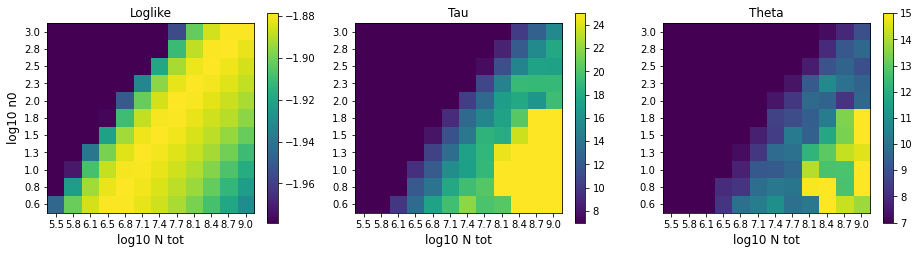

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,3.5))

ax1.set_title('Loglike', fontsize=12)
gbm.plot_heatmap(ax1, mean_ll, x, y, np.max(mean_ll) - 0.1, np.max(mean_ll), laby='log10 n0', labx='log10 N tot')

ax2.set_title('Tau', fontsize=12)
gbm.plot_heatmap(ax2, mean_tau, x, y, 7, 25, laby='', labx='log10 N tot')

ax3.set_title('Theta', fontsize=12)
gbm.plot_heatmap(ax3, mean_theta, x, y, 7, 15, laby='', labx='log10 N tot')

plt.tight_layout()
#plt.savefig('plots/gbm/ll_at_Mtot_n0_pat'+label+'_nmin1.svg')

### Choosing the parameters and errors by looking at the best ranked log-likelihood

In [30]:
std_taus_at_ll_rank, av_taus_at_ll_rank = [], []
std_alpha_at_ll_rank, av_alpha_at_ll_rank = [], []
std_theta_at_ll_rank, av_theta_at_ll_rank = [], []
lls_at_rank = []
for ll_rank in range(2, 40):
    iranks = np.argsort(mean_ll.flatten())[::-1]
    lls_at_rank.append(mean_ll.flatten()[iranks[ll_rank]])
    taus = mean_tau.flatten()[iranks[:ll_rank]]
    thetas = mean_theta.flatten()[iranks[:ll_rank]]
    alphas = thetas * 2 / taus
    av_taus_at_ll_rank.append(np.mean(taus))
    std_taus_at_ll_rank.append(np.std(taus))
    av_theta_at_ll_rank.append(np.mean(thetas))
    std_theta_at_ll_rank.append(np.std(thetas))
    av_alpha_at_ll_rank.append(np.mean(alphas))
    std_alpha_at_ll_rank.append(np.std(alphas))

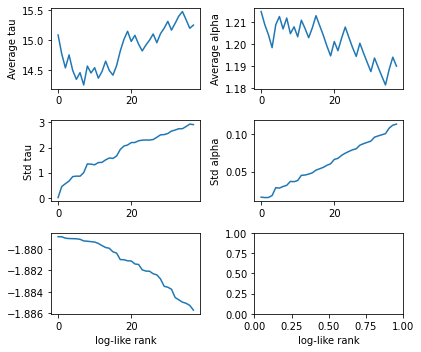

In [32]:
fig, axs = plt.subplots(3,2,figsize=(6,5))

axs[0][0].plot(av_taus_at_ll_rank)
axs[0][0].set_ylabel('Average tau')
axs[1][0].plot(std_taus_at_ll_rank)
axs[1][0].set_ylabel('Std tau')
axs[2][0].set_xlabel('log-like rank')

axs[0][1].plot(av_alpha_at_ll_rank)
axs[0][1].set_ylabel('Average alpha')
axs[1][1].plot(std_alpha_at_ll_rank)
axs[1][1].set_ylabel('Std alpha')
axs[2][1].set_xlabel('log-like rank')

axs[2][0].plot(lls_at_rank)

plt.tight_layout()
#plt.savefig('plots/gbm/params_at_llrank_pat'+label+'_nmin1.svg')

In [33]:
rank_plateau = 10
print('tau', av_taus_at_ll_rank[rank_plateau], '+-', std_taus_at_ll_rank[rank_plateau])
print('alpha', av_alpha_at_ll_rank[rank_plateau], '+-', std_alpha_at_ll_rank[rank_plateau])

tau 14.536089794964683 +- 1.3136014290093263
alpha 1.2032948049422345 +- 0.038244680026591885


### Fitting the ridge of maximum lileihood

[ 1.13237825 -6.91158447] [-5.89636364]
787705.0620177357 3.956373025842359 126951.06940641755 1544955.713501258


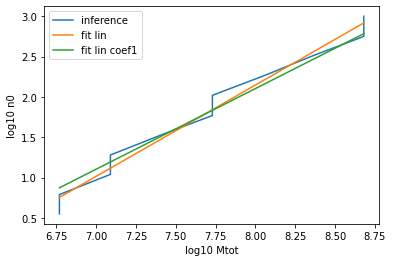

In [35]:
from scipy.optimize import curve_fit

def lin(x, a, b):
    return a * x + b

def lin_1(x, b):
    return x + b

M_tot_max = x[np.argmax(mean_ll, axis=1)]
max_n0_i = len(y) - 0
par_fit, cov = curve_fit(lin, M_tot_max[:max_n0_i], y[:max_n0_i])
par_fit_1, cov1 = curve_fit(lin_1, M_tot_max[:max_n0_i], y[:max_n0_i])
print(par_fit, par_fit_1)

plt.xlabel('log10 Mtot')
plt.ylabel('log10 n0')
plt.plot(M_tot_max[:max_n0_i], y[:max_n0_i], label='inference')
y_fit = lin(M_tot_max, par_fit[0], par_fit[1])
plt.plot(M_tot_max, y_fit, label='fit lin')
y_fit = lin_1(M_tot_max, par_fit_1[0])

ratio = 10**(-par_fit_1[0])
birth_rate = gbm.birth_rate(ratio, av_taus_at_ll_rank[rank_plateau], av_theta_at_ll_rank[rank_plateau])
n0 = 10**(11 + par_fit_1[0])
alpha = 2 * av_theta_at_ll_rank[rank_plateau] / av_taus_at_ll_rank[rank_plateau]
N = (alpha - 1) / alpha * ratio * np.log(n0)
print(ratio, np.log10(birth_rate), n0, N)
plt.plot(M_tot_max, y_fit, label='fit lin coef1')
plt.legend()

In [12]:
def write_on_file(path):
    f = open(path, 'w')
    f.write('n_points:\t' + str(pars['n_eval']) + str('\n'))
    f.write('logM_logn0_slope:\t' + str(par_fit[0]) + str('\n'))
    f.write('logM_logn0_offset:\t' + str(par_fit[1]) + str('\n'))
    f.write('logM_logn0_offset_slope1:\t' + str(par_fit_1[0]) + str('\n'))
    f.write('plateau_rank:\t' + str(rank_plateau) + str('\n'))
    m_ll = mean_ll.flatten()[np.argsort(mean_ll.flatten())[::-1][:rank_plateau]].mean()
    f.write('mean_ll:\t' + str(m_ll) + str('\n'))
    f.write('tau:\t' + str(av_taus_at_ll_rank[rank_plateau]) + str('\n'))
    f.write('theta:\t' + str(av_theta_at_ll_rank[rank_plateau]) + str('\n'))
    f.write('alpha:\t' + str(av_alpha_at_ll_rank[rank_plateau]) + str('\n'))
    f.write('tau_err:\t' + str(std_taus_at_ll_rank[rank_plateau]) + str('\n'))
    f.write('theta_err:\t' + str(std_theta_at_ll_rank[rank_plateau]) + str('\n'))
    f.write('alpha_err:\t' + str(std_alpha_at_ll_rank[rank_plateau]) + str('\n'))
    f.write('birth_rate:\t' + str(birth_rate) + str('\n'))
    f.write('n0:\t' + str(n0) + str('\n'))
    f.write('N:\t' + str(N) + str('\n'))
    f.close()
    
write_on_file('inference/gbm/pat'+label+'_nmin1.txt')

### Example at given M_tot, n0

In [17]:
M_tot = 10**10
n0 = 10**(lin(np.log10(M_tot), 1, par_fit_1[0]))
print(n0)

42037.44998607096


In [19]:
infer_pars = gbm.gbm_infer_pars(dtimes, M_tot, n0, 1, int(pars['n_eval']), priors)
bounds = [(pars['bounds00'], pars['bounds01']), (pars['bounds10'], pars['bounds11'])]
ls = [pars['lenght_scales0'], pars['lenght_scales1']]
%time res = gbm.learn_gbm_gp(sp_counts, infer_pars, bounds=bounds, n_calls=150, \
                             noise=pars['noise'], lenght_scales=ls, xi=pars['xi'], n_jobs=2)
res.x[0], res.fun

CPU times: user 8min 34s, sys: 12min 37s, total: 21min 12s
Wall time: 6min 34s


(15.897767854515152, 1.4469249542611928)

In [15]:
def write_on_file_exe(path):
    f = open(path, 'w')
    f.write('n_points:\t' + str(infer_pars.n_eval) + str('\n'))
    f.write('M_tot:\t' + str(M_tot) + str('\n'))
    f.write('n0:\t' + str(n0) + str('\n'))
    f.write('ll:\t' + str(-res.fun) + str('\n'))
    f.write('tau:\t' + str(res.x[0]) + str('\n'))
    f.write('theta:\t' + str(res.x[0] * res.x[1] / 2.0) + str('\n'))
    f.close()
    
write_on_file_exe('inference/gbm/pat'+label+'_nmin1_exe.txt')